In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


* Get the stock data from Yahoo finance as a CSV for any company. 

* Drop all other columns (Volume, Year, Month and Day) and retain Open, High and Close - since I'm just predicting the close value for a day

In [2]:
def get_stock_data(stock_name, normalized=0):
    url = 'http://chart.finance.yahoo.com/table.csv?s=%s&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv' % stock_name

    col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stocks = pd.read_csv(url, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    date_split = df['Date'].str.split('-').str
    df['Year'], df['Month'], df['Day'] = date_split
    df["Volume"] = df["Volume"] / 10000
    #df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1, inplace=True) 
    return df

In [3]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name,0)
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Year,Month,Day
0,2017-03-24,842.000000,844.000000,829.099976,835.140015,209.26,835.140015,2017,03,24
1,2017-03-23,841.390015,841.690002,833.000000,839.650024,328.52,839.650024,2017,03,23
2,2017-03-22,849.479980,855.349976,847.000000,849.799988,135.80,849.799988,2017,03,22
3,2017-03-21,870.059998,873.469971,847.690002,850.140015,251.52,850.140015,2017,03,21
4,2017-03-20,869.479980,870.340027,864.669983,867.909973,150.14,867.909973,2017,03,20


In [4]:
df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1, inplace=True)
df.head()

,Open,High,Close
0,842.000000,844.000000,835.140015
1,841.390015,841.690002,839.650024
2,849.479980,855.349976,849.799988
3,870.059998,873.469971,850.140015
4,869.479980,870.340027,867.909973


* Let me save the data to a CSV file so that I can refer later (if needed :) ) 

In [16]:
today = datetime.date.today()
filename = stock_name+'_stock_%s.csv' % today
df.to_csv(filename)

Normalizing

In [5]:
df['Open'] = df['Open']/100
df['High'] = df['High']/100
df['Close'] = df['Close']/100
df.head()

,Open,High,Close
0,8.4200,8.4400,8.3514
1,8.4139,8.4169,8.3965
2,8.4948,8.5535,8.4980
3,8.7006,8.7347,8.5014
4,8.6948,8.7034,8.6791


In [6]:
#Load the data
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [7]:
#Build the model
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='linear'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

Divide as Training and Test set

In [8]:
window = 22
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1173, 22, 3)
y_train (1173,)
X_test (130, 22, 3)
y_test (130,)


In [9]:
# model = build_model([3,lag,1])
model = build_model2([3,window,1])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="linear", kernel_initializer="uniform")`


Execute the trained model

In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=500,
    validation_split=0.1,
    verbose=1)

Train on 1055 samples, validate on 118 samples

Epoch 1/500
1055/1055 [==============================] - 6s - loss: 54.5698 - acc: 0.0000e+00 - val_loss: 56.6067 - val_acc: 0.0000e+00
Epoch 2/500
1055/1055 [==============================] - 4s - loss: 54.2361 - acc: 0.0000e+00 - val_loss: 56.1267 - val_acc: 0.0000e+00
Epoch 3/500
1055/1055 [==============================] - 3s - loss: 53.7573 - acc: 0.0000e+00 - val_loss: 55.5052 - val_acc: 0.0000e+00
Epoch 4/500
1055/1055 [==============================] - 3s - loss: 53.1317 - acc: 0.0000e+00 - val_loss: 54.6624 - val_acc: 0.0000e+00
Epoch 5/500
1055/1055 [==============================] - 3s - loss: 52.2918 - acc: 0.0000e+00 - val_loss: 53.5170 - val_acc: 0.0000e+00
Epoch 6/500
1055/1055 [==============================] - 3s - loss: 51.1431 - acc: 0.0000e+00 - val_loss: 52.0444 - val_acc: 0.0000e+00
Epoch 7/500
1055/1055 [==============================] - 3s - loss: 49.7124 - acc: 0.0000e+00 - val_loss: 50.2901 - val_acc: 0.0000e+00
Epoch 8/500
1055/1055 [==============================] - 3s - loss: 48.0304 - acc: 0.0000e+00 - val_loss: 48.4176 - val_acc: 0.0000e+00
Epoch 9/500
1055/1055 [==============================] - 3s - loss: 46.2073 - acc: 0.0000e+00 - val_loss: 46.4271 - val_acc: 0.0000e+00
Epoch 10/500
1055/1055 [==============================] - 3s - loss: 44.2880 - acc: 0.0000e+00 - val_loss: 44.3134 - val_acc: 0.0000e+00

Epoch 490/500
1055/1055 [==============================] - 6s - loss: 3.3352 - acc: 0.0000e+00 - val_loss: 0.2747 - val_acc: 0.0000e+00
Epoch 491/500
1055/1055 [==============================] - 6s - loss: 3.3220 - acc: 0.0000e+00 - val_loss: 0.3347 - val_acc: 0.0000e+00
Epoch 492/500
1055/1055 [==============================] - 6s - loss: 3.3430 - acc: 0.0000e+00 - val_loss: 0.3876 - val_acc: 0.0000e+00
Epoch 493/500
1055/1055 [==============================] - 6s - loss: 3.3882 - acc: 0.0000e+00 - val_loss: 0.3919 - val_acc: 0.0000e+00
Epoch 494/500
1055/1055 [==============================] - 6s - loss: 3.3117 - acc: 0.0000e+00 - val_loss: 0.3515 - val_acc: 0.0000e+00
Epoch 495/500
1055/1055 [==============================] - 7s - loss: 3.4429 - acc: 0.0000e+00 - val_loss: 0.3073 - val_acc: 0.0000e+00
Epoch 496/500
1055/1055 [==============================] - 7s - loss: 3.3748 - acc: 0.0000e+00 - val_loss: 0.2877 - val_acc: 0.0000e+00
Epoch 497/500
1055/1055 [==============================] - 6s - loss: 3.3394 - acc: 0.0000e+00 - val_loss: 0.2870 - val_acc: 0.0000e+00
Epoch 498/500
1055/1055 [==============================] - 6s - loss: 3.3265 - acc: 0.0000e+00 - val_loss: 0.2725 - val_acc: 0.0000e+00
Epoch 499/500
1055/1055 [==============================] - 6s - loss: 3.3056 - acc: 0.0000e+00 - val_loss: 0.2654 - val_acc: 0.0000e+00
Epoch 500/500
1055/1055 [==============================] - 6s - loss: 3.3673 - acc: 0.0000e+00 - val_loss: 0.2697 - val_acc: 0.0000e+00

In [11]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 2.87 MSE (1.69 RMSE)
Test Score: 1.11 MSE (1.05 RMSE)


Predictions vs Real results

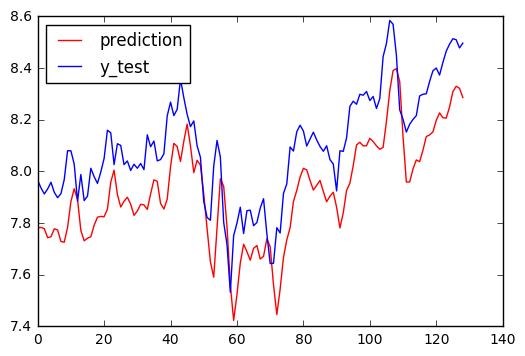

In [24]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()